# Ciencia de Datos - TP1 - Estadística básica

In [30]:
import numpy as np
from scipy import stats
from scipy import stats as st
import statsmodels.sandbox.stats.multicomp as sms
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Our permutation test 
def my_permtest(a, b, nr_perms, alpha, one_tail=False):
    # This function performs a Permutation Test (for now it works with paired data only)
    # a, b: pd.Series with values corresponding to each condition...
    # ... a, b implies that hypothesis is a > b
    # nr_perms:  int; number of permutations
    # alpha: float; between 0-1 representing significance threshold
    # NaNs are ignored

    emp_vals = np.vstack((a, b)).reshape(len(a), 2)  # Stack both sets of values
    emp_avg_diff = np.nanmean(np.subtract(a, b))  # Empirical mean difference
    perm_dist = list([])  # Initialize list (empty permutation distribution)

    for perm in range(0, nr_perms):
        label_perm = np.array([list(np.random.choice([0, 1], 2, replace=False))  # array with pair-wise permuted labels
                               for x in range(0, len(a))]).reshape([len(a), 2])  # labels --> 0 / 1

        # Generate permutation of paired values
        perm_vals = np.vstack((emp_vals[range(0, len(a)), label_perm[:, 0]],  # ...and flip back to vertical array
                               emp_vals[range(0, len(a)), label_perm[:, 1]])).swapaxes(0, 1)

        perm_avg_diff = np.nanmean(perm_vals[:, 0] - perm_vals[:, 1])  # permutation mean difference

        perm_dist.append(perm_avg_diff)  # Add perm diff to permutation distribution

    stat = emp_avg_diff  # Compute summary statistic (in this case it's just the mean difference)

    if one_tail:
        alpha_bis = alpha
        p_value = (100 - st.percentileofscore(np.array(perm_dist), stat)) / 100
        # Compute critical value given alpha, permutations
        crit_val = np.percentile(perm_dist, np.multiply(1 - alpha_bis, 100))

        if p_value <= alpha_bis:
            signif_message = 'one-tailed test, significant at alpha=' + str(alpha)
        else:
            signif_message = 'one-tailed test, not significant at alpha=' + str(alpha)

    # Calulate p-value from percentile of stat in perm_dist
    else:  # if two-tailed
        alpha_bis = alpha / 2
        if stat < 0:
            p_value = (100 - st.percentileofscore(np.array(perm_dist) * -1, stat * -1)) / 100
            crit_val = np.percentile(perm_dist, np.multiply(alpha_bis, 100))  # Critical value for negative statistic

        else:
            p_value = (100 - st.percentileofscore(np.array(perm_dist), stat)) / 100
            # Compute critical value given alpha, permutations
            crit_val = np.percentile(perm_dist, np.multiply(1 - alpha_bis, 100))

        if p_value <= alpha_bis:
            signif_message = 'two-tailed test, significant at alpha=' + str(alpha)
        else:
            signif_message = 'two-tailed test, not significant at alpha=' + str(alpha)

    # Calculate minimum possible p-value based on number of permutations
    p_min = 1 / nr_perms
    if p_value < p_min:
        p_value = p_min
        symb = '< '
    else:
        symb = '= '
    return p_value, stat, crit_val, perm_dist, symb, signif_message

In [32]:
main_path = '/home/martinagv/Documents/CienciaDatos/cdd' # Get main path from current directory

raw_data = pd.read_csv(main_path + '/raw_data.txt', delimiter=' ')  # Load data into pandas dataframe

## Exploración de datos

In [33]:
print(raw_data)

    Atleta  tiempo_sol  tiempo_nublado  tiempo_lluvia
0        1        11.1            11.3           19.4
1        2        13.0            12.8           18.2
2        3        16.1            16.0           19.0
3        4        14.5            14.1           18.9
4        5        12.0            12.5           19.1
5        6        11.0            11.6           18.7
6        7        15.1            14.6          189.0
7        8        14.4            14.2           19.9
8        9        16.1            16.1           18.5
9       10        17.0            16.7           19.2
10      11        12.2            12.4           18.8
11      12        14.4            14.1           19.2


In [34]:
# RE-ARRANGE RAW DATA for visualization and statistical analyses
data_pivoted = raw_data.drop('Atleta', 1).stack()  # Stack columns (previous columns now as multi-indices)
df = pd.DataFrame(data_pivoted)  # Back to dataframe format (data_pivoted is pd.Series)
df.reset_index(inplace=True)  # Indices to values in columns (to get a column with athlete number)
df.columns = ['atleta', 'clima', 'tiempo']  # Rename columns (in place)

In [35]:
print(df)

    atleta           clima  tiempo
0        0      tiempo_sol    11.1
1        0  tiempo_nublado    11.3
2        0   tiempo_lluvia    19.4
3        1      tiempo_sol    13.0
4        1  tiempo_nublado    12.8
5        1   tiempo_lluvia    18.2
6        2      tiempo_sol    16.1
7        2  tiempo_nublado    16.0
8        2   tiempo_lluvia    19.0
9        3      tiempo_sol    14.5
10       3  tiempo_nublado    14.1
11       3   tiempo_lluvia    18.9
12       4      tiempo_sol    12.0
13       4  tiempo_nublado    12.5
14       4   tiempo_lluvia    19.1
15       5      tiempo_sol    11.0
16       5  tiempo_nublado    11.6
17       5   tiempo_lluvia    18.7
18       6      tiempo_sol    15.1
19       6  tiempo_nublado    14.6
20       6   tiempo_lluvia   189.0
21       7      tiempo_sol    14.4
22       7  tiempo_nublado    14.2
23       7   tiempo_lluvia    19.9
24       8      tiempo_sol    16.1
25       8  tiempo_nublado    16.1
26       8   tiempo_lluvia    18.5
27       9      tiem

Utilizamos un stripplot con el fin de visualizar la distribución de los datos y evaluar la presencia de valores extremos. Cada punto del gráfico representa el tiempo en segundos obtenido para cada sujeto en cada condición climática (las condiciones se encuentra graficadas con un color diferente). 

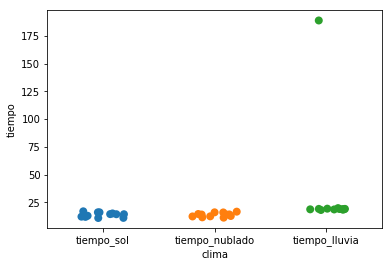

In [36]:
# Visualize using strip plot
ax = sns.stripplot(x='clima', y='tiempo', hue='clima', data=df, jitter=0.2, size=8)
ax.legend().set_visible(False)  # Remove hue legend (names already in x labels)

### Limpieza de datos

El stripplot parece indicar que existe al menos un outlier en los datos. Para removerlo, se decidió utilizar como criterio el número de desviaciones estándar. De esta manera, se extrae un dato del análisis si representa un valor por encima de tres desvíos estándar sobre la media del grupo de datos (condición climática) al cuál pertenece. 

In [37]:
conds = raw_data.columns.values[1:]  # Get array with condition names

In [38]:
raw_data = pd.DataFrame(raw_data) # Convert raw data to DataFrame

for cond in conds:  # For data in each condition
    avg = df[df['clima'] == cond]['tiempo'].mean()  # Compute mean of current condition values
    disp = df[df['clima'] == cond]['tiempo'].std()  # Compute std of current condition values
    out_criterion = disp * 3  # Specific threshold for removing outliers

    outlier_count = np.sum([(df['clima'] == cond) &
                            (abs(df['tiempo'] - avg) > out_criterion)])  # Count outliers in current cond

    df['tiempo'][(df['clima'] == cond) &
                 (abs(df['tiempo'] - avg) > out_criterion)] = None  # Assign NaN to outlier in second format of table

    raw_data[cond][(abs(raw_data[cond] - avg) > out_criterion)] = None # Assign NaN to outlier in first format of table

    print('Removed ' + str(outlier_count) + ' outlier(s) in ' + cond)  # Print outlier count


Removed 0 outlier(s) in tiempo_sol
Removed 0 outlier(s) in tiempo_nublado
Removed 1 outlier(s) in tiempo_lluvia


In [39]:
# Visualize first table format with outlier removed 
print(raw_data)

    Atleta  tiempo_sol  tiempo_nublado  tiempo_lluvia
0        1        11.1            11.3           19.4
1        2        13.0            12.8           18.2
2        3        16.1            16.0           19.0
3        4        14.5            14.1           18.9
4        5        12.0            12.5           19.1
5        6        11.0            11.6           18.7
6        7        15.1            14.6            NaN
7        8        14.4            14.2           19.9
8        9        16.1            16.1           18.5
9       10        17.0            16.7           19.2
10      11        12.2            12.4           18.8
11      12        14.4            14.1           19.2


In [40]:
# Visualize second table format with outlier removed
print(df)

    atleta           clima  tiempo
0        0      tiempo_sol    11.1
1        0  tiempo_nublado    11.3
2        0   tiempo_lluvia    19.4
3        1      tiempo_sol    13.0
4        1  tiempo_nublado    12.8
5        1   tiempo_lluvia    18.2
6        2      tiempo_sol    16.1
7        2  tiempo_nublado    16.0
8        2   tiempo_lluvia    19.0
9        3      tiempo_sol    14.5
10       3  tiempo_nublado    14.1
11       3   tiempo_lluvia    18.9
12       4      tiempo_sol    12.0
13       4  tiempo_nublado    12.5
14       4   tiempo_lluvia    19.1
15       5      tiempo_sol    11.0
16       5  tiempo_nublado    11.6
17       5   tiempo_lluvia    18.7
18       6      tiempo_sol    15.1
19       6  tiempo_nublado    14.6
20       6   tiempo_lluvia     NaN
21       7      tiempo_sol    14.4
22       7  tiempo_nublado    14.2
23       7   tiempo_lluvia    19.9
24       8      tiempo_sol    16.1
25       8  tiempo_nublado    16.1
26       8   tiempo_lluvia    18.5
27       9      tiem

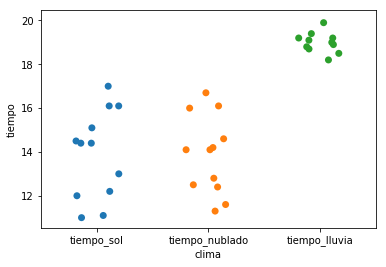

In [41]:
# Visualize again (outliers removed)
ax = sns.stripplot(x='clima', y='tiempo', hue='clima', data=df, jitter=0.2, size=7)
ax.legend().set_visible(False)  # Remove hue legend (names already in x labels)

### Explorar dependencias e independencias

Para visualizar cualitativamente si la velocidad en los días de sol, nublados, o con lluvia es independiente o dependiente del atleta, graficaremos los datos con la técnica de stripplot en donde un color particular represente a cada atleta. Si la velocidad en las distintas condiciones climáticas fuera dependiente del atleta, esperaríamos que el orden con el cual los puntos (representantes de cada sujeto) se alinien en el eje "tiempo" se mantenga constante a través de las condiciones. 

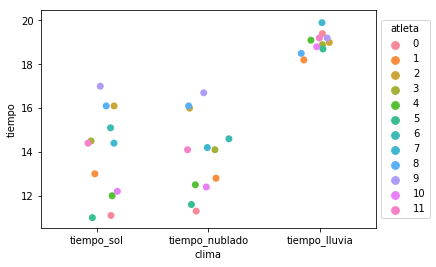

In [42]:
plt.figure()  # Better visualization (identifies individual athletes)
ax = sns.stripplot(x='clima', y='tiempo', hue='atleta', data=df, jitter=0.2, size=7);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('atleta');  # Identifica atleta con color

Para visualizar cuantitativamente si la velocidad en los días de sol, nublados, o con lluvia es independiente o dependiente del atleta, computaremos la correlación entre las diferentes condiciones climáticas. Si la velocidad en la condición climática fuera dependiente del atleta, esperaríamos que el coeficiente de correlación entre las condiciones sea elevado, y el p-valor de la comparación sea menor a 0.05. 

Correlation (tiempo_sol and tiempo_nublado): r = 0.959, p = 3.1259e-06
Correlation (tiempo_sol and tiempo_lluvia): r = 0.055, p = 0.8734465775
Correlation (tiempo_nublado and tiempo_lluvia): r = 0.08, p = 0.8161621936


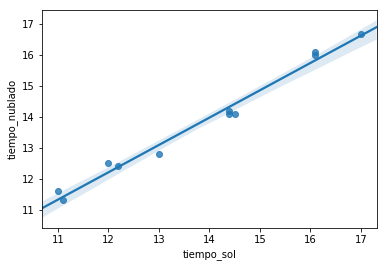

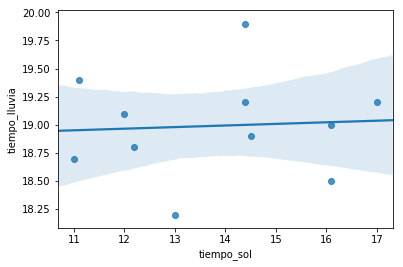

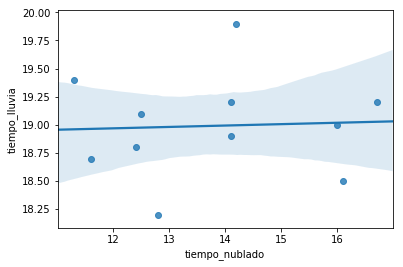

In [44]:
for pair in list(itertools.combinations(conds, 2)):

    raw_data.iloc[6] = np.nan  # remove all raw of outlier

    cond1 = raw_data[pair[0]] # assign condition 1
    cond2 = raw_data[pair[1]] # assign condition 2 

    plt.figure()
    sns.regplot(x=cond1, y=cond2, data=raw_data) # plot correlation
    corr_coeff, p_corr = stats.spearmanr(cond1, cond2, nan_policy='omit') # obtain r and p-value
    print('Correlation (' + pair[0] + ' and ' + pair[1] + '): '
          + 'r = ' + str(round(corr_coeff, 3)) + ', p = ' + str(p_corr.data.round(10)))


Encontramos que tanto el análisis cuantitativo como cualitativo respalda la siguiente interpretación: la velocidad en días soleados y nublados es dependiente del atleta, mientras que en días de lluvia es independiente del atleta.  En días soleados y nublados los atletas parecen mantener un cierto orden de desempeño (ej. el más rápido durante el entrenamiento con sol continúa siendo el más rápido durante el entrenamiento en días nublados). Sin embargo, la condición de lluvia no mantiene el orden observado ni en la condición de sol, ni en la condición de nubes. 
 

Ahora bien, el abordaje anterior del enunciado  "la velocidad en días de lluvia es independiente del atleta" nos limita a interpretar el problema como el mantenimiento del orden de desempeño de los sujetos a través de las condiciones. Otra perspectiva es posible: la velocidad en días de lluvia representa un decremento en velocidad con respecto a las demás condiciones, para todos los sujetos. Esto sería equivalente a decir que el resultado de la resta "[(velocidad en días de lluvia) - (velocidad en otra condición climática)]" será positivo para todos los sujetos. Como ejemplo:

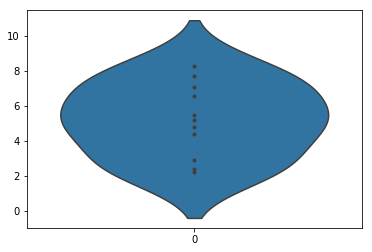

In [45]:
# Plot difference betweeen cond tiempo_sol and cond tiempo_lluvia for each subject
plt.figure()
difference = raw_data['tiempo_lluvia'] - raw_data['tiempo_sol']  # Vector with difference values for each subj
difference = pd.DataFrame(difference)  # Back to DataFrame format
difference.reset_index(inplace=True)  # Convert subj index into column
difference.columns = ['suj', 'difference']  # Rename columns
ak = sns.violinplot(data=difference['difference'], inner="points")  # Plot distribution, each dot is a subject

El análisis indica que los resultados siempre son positivos para esta resta. Por lo tanto, la condición de lluvia siempre representa un decremento de la velocidad del atleta con respecto a la condición de sol, independientemente del sujeto que evaluemos. 

## Test estadísticos

Shapiro Wilkinson(tiempo_sol): (0.9382138848304749, 0.47528600692749023)
Shapiro Wilkinson(tiempo_nublado): (0.9423919916152954, 0.5296684503555298)
Shapiro Wilkinson(tiempo_lluvia): (0.9852456450462341, 0.9883151054382324)


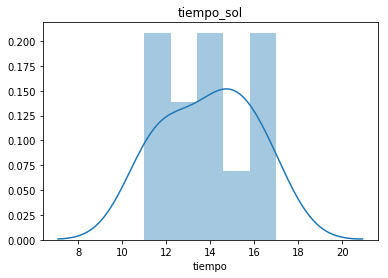

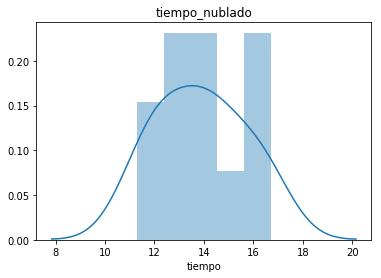

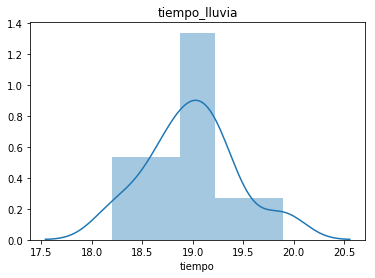

In [46]:
# Plot distribution for each condition
for cond in conds:
    plt.figure(cond)
    plt.title(cond)
    sns.distplot(df['tiempo'][df['clima'] == cond].dropna(), bins='auto')  # dropna() to ignore NaN values
    
    condition = df['tiempo'][df['clima'] == cond].dropna() # drop nans
    sh_res = stats.shapiro(condition) # run Shapiro Wilkinson to test normality
    print('Shapiro Wilkinson(' + cond + '): ' + str(sh_res))


Dado que el test de Shapiro-Wilkinson no logra rechazar la hipótesis nula (la cual afirma que los datos están distribuídos normalmente), no tenemos razones para sospechar que se necesitan test no paramétricos para las comparaciones estadísticas. Por lo tanto, llevaremos a cabo two-tailed t-test para evaluar la diferencia entre cada posible par de condiciones climáticas. Para complementar el análisis anterior, compararemos las condiciones con un test de permutaciones de una sola cola para testear las hipótesis de direccionalidad. Los p-values obtenidos en todos los test serán corregidos por FDR.

In [47]:
# Compute t-test and permutation tests
pvals = [] # Create list of p-values
comparison = [] # Create list of conditions compared

for pair in list(itertools.combinations(conds, 2)):
    cond1 = df['tiempo'][df['clima'] == pair[0]]
    cond2 = df['tiempo'][df['clima'] == pair[1]]

    # Pair-wise t-tests (paired data)
    t_value, p_value = stats.ttest_rel(cond2, cond1, nan_policy='omit')
    comparison.append(str(pair[1] + ' vs ' + pair[0]))
    pvals.append(p_value)

    print(pair[1] + ' vs ' + pair[0] + ': ' +
          't = ' + str(round(t_value, 6)),
          ', p = ' + str(round(p_value, 6)))

    # Permutation test
    p_value, stat, crit_val, perm_dist, symb, signif_message = my_permtest(cond2, cond1, nr_perms=1000, alpha=0.05, one_tail=True)
    print(pair[1] + ' vs ' + pair[0] + ': ' + 'stat = '
          + str(round(stat, 6)), ', p ' + symb + str(round(p_value, 6)))
    comparison.append(str(pair[1] + ' vs ' + pair[0]))
    pvals.append(p_value)


tiempo_nublado vs tiempo_sol: t = -0.412138 , p = 0.688156
tiempo_nublado vs tiempo_sol: stat = -0.041667 , p = 0.5525
tiempo_lluvia vs tiempo_sol: t = 8.16598 , p = 1e-05
tiempo_lluvia vs tiempo_sol: stat = 5.190909 , p < 0.001
tiempo_lluvia vs tiempo_nublado: t = 9.092864 , p = 4e-06
tiempo_lluvia vs tiempo_nublado: stat = 5.190909 , p < 0.001


In [50]:
# Handle multiple testing problem #
rejected, p_corr, p_bonf, p_sidak = sms.multipletests(pvals, alpha=0.05, method='fdr_bh',
                                                      is_sorted=False, returnsorted=False)  # Correct p-values

# Show p-corrected values
for i in range(0,6):
    print('p value corrected(' + str(comparison[i]) + '): ' + str(round(p_corr[i], 5)))

p value corrected(tiempo_nublado vs tiempo_sol): 0.68816
p value corrected(tiempo_nublado vs tiempo_sol): 0.663
p value corrected(tiempo_lluvia vs tiempo_sol): 3e-05
p value corrected(tiempo_lluvia vs tiempo_sol): 0.0015
p value corrected(tiempo_lluvia vs tiempo_nublado): 2e-05
p value corrected(tiempo_lluvia vs tiempo_nublado): 0.0015


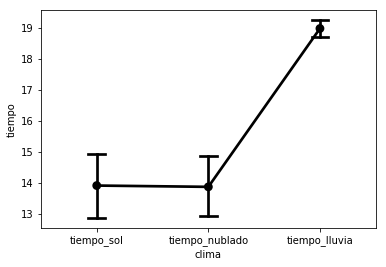

In [49]:
# Plot paired means and 95% CIs for each condition
plt.figure()
ax = sns.pointplot(x='clima', y='tiempo', data=df, ci=95,
                   units='atleta', color='k', capsize=0.15)  # [units] accounts for repeated measures design

Los resultados obtenidos indican que los altetas son significativamente más lentos en días de lluvia que en días soleados (p < .05). Este dato fue obtenido haciendo el test de permutaciones con una sola cola en la dirección esperada (bajo la hipótesis de que la media de la velocidad en días de lluvia sería significativamente mayor que la media en días de sol o de nubes). 

La velocidades del atleta no se diferencian signitficativamente entre las condiciones de clima soleado y clima nublado.

No hay evidencia para afirmar que el cielo nublado influye en los tiempos de los atletas. El efecto de cielo nublado se evidencia en su comparación con la condición de tiempo soleado, y enontramos que ambas no se diferencian significativamente (p > .05). El efecto de cielo nublado no puede ser obtenido de la comparación con tiempo lluvia, ya que esta última también conlleva un clima con nubes.  


Para responder la pregunta de si el clima influye en la velocidad de los atletas, podríamos tomar dos abordajes. El primero sería considerar que el clima influye en la velocidad si al menos una de las condiciones climáticas se diferencia significativamente de otra. Esto sería equivalente a desglosar el enunciado "El clima influye en la velocidad de los atletas" en proposiciones unidas por el conector lógico OR (ej. la velocidad de los atletas en días soleados es significativamente diferente a la obtenida en días nublados OR la velocidad de los atletas en días nublados es significativamente diferente a la obtenida en días con lluvia OR ...). De esta manera, bastaría con que una sola proposición sea verdadera (ej. la velocidad de los atletas en clima lluvioso es significativamente diferente a la obtenida durante días soleados) para que el enunciado sea verdadero. Si tomaramos esta perspectiva con los datos de este trabajo, concluíriamos que el clima influye en la velocidad de los atletas, ya que la velocidad de los atletas en días de lluvia se diferencia de la obtenida en días de sol (y también de la obtenida en días nublados). 
La segunda opción sería tomar una perspectiva en la cual las preposiciones del enunciado se encuentran unidas por el conector lógico AND. Para que el enunciado sea verdadero, todas las proposiciones deben ser verdaderas. En otras palabras, todas las condiciones climáticas deben diferenciarse significativamente entre sí. Si tomaramos este abordaje con los datos de este trabajo, concluíriamos que el clima no influye en la velocidad de los atletas ya que, por ejemplo, la velocidad de los atletas en días de sol no difiere de su velocidad en días nublados. Si solo la condición de lluvia se diferencia del resto de las condiciones, quizá su efecto se deba a otro factor (ej. presencia de agua) y no a la condición climática per se. 

## Consejos al entrenador

A partir de los datos analizados, no podemos asegurar que entrenar en días de lluvia sea de gran utilidad. Los resultados nos dicen que entrenar en días de lluvia disminuye la velocidad de los atletas con respecto a otras condiciones climáticas. Sin embargo, nada nos dicen sobre si es preferible entrenar con lluvia a no hacer nada durante los días con este clima. Para responder a esta pregunta, deberíamos de evaluar cómo mejora el desempeño del atleta a través de los entrenamientos en diversas condiciones climáticas. La manera más eficiente de hacerlo sería llevar a cabo un experimento en el cual los sujetos sean separados en cuatro grupos. Uno entrenará sólo con días de sol, otro con días nublados, otro con días de lluvia, y otro no entrenará. El entrenamiento se llevará a cabo a través de un lapso de tiempo, y se evaluará la velocidad de cada sujeto en dos instancias: una antes de comenzar el período de entrenamiento (medida "pre") y otra al finalizarlo (medida "post"). En el caso del grupo de no entrenamiento, se tomarán estas medidas a la par que los otros grupos. La velocidad de los sujetos se medirá siempre en días soleados (independientemente del grupo al que pertenezcan) para que los resultados no dependan de la condición climática bajo la cuál se los evaluó. Si entrenar con lluvia fuera mejor que no entrenar, debería de existir una diferencia significativa entre la medida pre y post en el grupo de entrenamiento con lluvia (en donde la medida post tenga velocidades menores a la medida pre), mientras que el grupo que no entrenó no debería de mostrar diferencias a través del tiempo. De esta manera, existiría evidencia de que entrenar con lluvia es mejor que no hacer nada. Con este experimento, también podremos saber si entrenar en diferentes condiciones climáticas influye sobre el nivel general de desempeño.  
